# MLP Architectural Patterns: Bottleneck, Inverted Bottleneck, Multi-branch, Dense

Цель: изучить влияние различных архитектурных паттернов на обучение глубоких MLP сетей.

Данные: Wine Quality (мультиклассовая классификация) - переиспользуем препроцессинг из предыдущего семинара.

Структура:
1. Абстрактные базовые классы для MLP блока и DeepMLP
2. Residual Add блок (базовый для сравнения)
3. Bottleneck блок
4. Inverted Bottleneck блок
5. Multi-branch блок
6. Dense connections блок
7. Эксперименты с разными глубинами (2, 6, 12, 18, 24)

Метрики: Accuracy и F1 (macro); кривые train/val loss


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchmetrics.classification import (
    Accuracy, F1Score
)
import sys
sys.path.append('../../lesson3/seminar')
from wine_quality_data import WineQualityDataModule
from lightning_module import BaseLightningModule
from utils import set_seed
from pytorch_lightning import Trainer

sns.set_style("whitegrid")
set_seed(42)


## 1. Абстрактные базовые классы

Создаем абстрактные базовые классы для MLP блока и глубокой MLP сети, от которых будут наследоваться конкретные реализации.


In [2]:
from abc import ABC, abstractmethod

class BaseMLPBlock(nn.Module, ABC):
    """
    Абстрактный базовый класс для MLP блока.
    
    Args:
        dim: размерность входа
        hidden_dim: размерность скрытого слоя и выхода (если None, то равен dim)
        activation: функция активации ('relu', 'gelu', 'swish')
        dropout: вероятность dropout
    """
    def __init__(
        self,
        dim,
        hidden_dim=None,
        activation='relu',
        dropout=0.0
    ):
        super().__init__()
        
        self.dim = dim
        self.hidden_dim = hidden_dim if hidden_dim is not None else dim
        
        # Активация
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'swish':
            self.activation = nn.SiLU()
        else:
            self.activation = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
    
    @abstractmethod
    def forward(self, x):
        """
        Forward pass через блок.
        Выход всегда имеет размерность hidden_dim.
        """
        pass


class BaseDeepMLP(nn.Module, ABC):
    """
    Абстрактный базовый класс для глубокой MLP сети.
    
    Args:
        input_dim: размерность входа
        output_dim: размерность выхода
        hidden_dim: размерность скрытых слоев
        num_blocks: количество блоков
        block_kwargs: дополнительные аргументы для блока
    """
    def __init__(
        self,
        input_dim,
        output_dim,
        hidden_dim=128,
        num_blocks=4,
        block_kwargs=None
    ):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_blocks = num_blocks
        
        # Входной проекционный слой
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # Блоки (будут созданы в дочерних классах)
        self.blocks = None
        
        # Выходной слой
        self.output_proj = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.input_proj(x)
        
        if self.blocks is not None:
            for block in self.blocks:
                x = block(x)
        
        x = self.output_proj(x)
        return x


## 2. Residual Add блок (базовый для сравнения)

Блок с residual connection через сложение - используем как базовый для сравнения.


In [3]:
class ResidualAddMLPBlock(BaseMLPBlock):
    """
    MLP блок с residual connection через сложение (базовый для сравнения).
    
    Args:
        dim: размерность входа и выхода
        hidden_dim: размерность скрытого слоя (если None, то равен dim)
        activation: функция активации
        dropout: вероятность dropout
        residual_alpha: коэффициент масштабирования residual (α)
    """
    def __init__(
        self,
        dim,
        hidden_dim=None,
        activation='relu',
        dropout=0.0,
        residual_alpha=1.0
    ):
        super().__init__(dim, hidden_dim, activation, dropout)
        
        self.residual_alpha = residual_alpha
        
        # Линейные слои: dim -> hidden_dim -> hidden_dim
        self.linear1 = nn.Linear(self.dim, self.hidden_dim)
        self.linear2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        # Проекционный shortcut нужен, если размерности входа и выхода не совпадают
        if self.dim != self.hidden_dim:
            self.projection = nn.Linear(self.dim, self.hidden_dim)
        else:
            self.projection = None
    
    def forward(self, x):
        identity = x
        
        x = self.linear1(x)
        x = self.activation(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.linear2(x)
        x = self.activation(x)
        # Residual connection через сложение
        if self.projection is not None:
            identity = self.projection(identity)
        
        x = x + self.residual_alpha * identity
        
        return x


class ResidualAddDeepMLP(BaseDeepMLP):
    """
    Глубокая MLP сеть из ResidualAddMLPBlock.
    """
    def __init__(
        self,
        input_dim,
        output_dim,
        hidden_dim=128,
        num_blocks=4,
        block_kwargs=None
    ):
        super().__init__(input_dim, output_dim, hidden_dim, num_blocks, block_kwargs)
        
        block_kwargs = block_kwargs or {}
        self.blocks = nn.ModuleList([
            ResidualAddMLPBlock(dim=hidden_dim, hidden_dim=hidden_dim, **block_kwargs)
            for _ in range(num_blocks)
        ])


In [4]:
class BottleneckMLPBlock(BaseMLPBlock):
    """
    MLP блок с bottleneck архитектурой.
    
    Структура: dim -> bottleneck_dim -> dim (с residual connection)
    
    Args:
        dim: размерность входа и выхода
        bottleneck_dim: размерность узкого места (обычно dim // 4)
        activation: функция активации
        dropout: вероятность dropout
        residual_alpha: коэффициент масштабирования residual (α)
    """
    def __init__(
        self,
        dim,
        bottleneck_dim=None,
        activation='relu',
        dropout=0.0,
        residual_alpha=1.0
    ):
        super().__init__(dim, dim, activation, dropout)
        
        # Bottleneck dimension (обычно dim // 4)
        if bottleneck_dim is None:
            bottleneck_dim = max(dim // 4, 1)
        self.bottleneck_dim = bottleneck_dim
        
        self.residual_alpha = residual_alpha
        
        # Линейные слои: dim -> bottleneck_dim -> dim
        self.linear1 = nn.Linear(self.dim, self.bottleneck_dim)
        self.linear2 = nn.Linear(self.bottleneck_dim, self.dim)
    
    def forward(self, x):
        identity = x
        
        x = self.linear1(x)
        x = self.activation(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.linear2(x)
        x = self.activation(x)
        
        # Residual connection
        x = x + self.residual_alpha * identity
        
        return x


class BottleneckDeepMLP(BaseDeepMLP):
    """
    Глубокая MLP сеть из BottleneckMLPBlock.
    """
    def __init__(
        self,
        input_dim,
        output_dim,
        hidden_dim=128,
        num_blocks=4,
        block_kwargs=None
    ):
        super().__init__(input_dim, output_dim, hidden_dim, num_blocks, block_kwargs)
        
        block_kwargs = block_kwargs or {}
        self.blocks = nn.ModuleList([
            BottleneckMLPBlock(dim=hidden_dim, **block_kwargs)
            for _ in range(num_blocks)
        ])


## 4. Inverted Bottleneck блок

Inverted Bottleneck: сначала расширяем размерность (dim -> expanded_dim), затем сжимаем (expanded_dim -> dim).
Это позволяет увеличить емкость модели при сохранении входной/выходной размерности.


In [5]:
class InvertedBottleneckMLPBlock(BaseMLPBlock):
    """
    MLP блок с inverted bottleneck архитектурой.
    
    Структура: dim -> expanded_dim -> dim (с residual connection)
    
    Args:
        dim: размерность входа и выхода
        expansion_factor: коэффициент расширения (обычно 4)
        activation: функция активации
        dropout: вероятность dropout
        residual_alpha: коэффициент масштабирования residual (α)
    """
    def __init__(
        self,
        dim,
        expansion_factor=4,
        activation='relu',
        dropout=0.0,
        residual_alpha=1.0
    ):
        super().__init__(dim, dim, activation, dropout)
        
        # Expanded dimension
        expanded_dim = dim * expansion_factor
        self.expanded_dim = expanded_dim
        
        self.residual_alpha = residual_alpha
        
        # Линейные слои: dim -> expanded_dim -> dim
        self.linear1 = nn.Linear(self.dim, self.expanded_dim)
        self.linear2 = nn.Linear(self.expanded_dim, self.dim)
    
    def forward(self, x):
        identity = x
        
        x = self.linear1(x)
        x = self.activation(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.linear2(x)
        x = self.activation(x)
        
        # Residual connection
        x = x + self.residual_alpha * identity
        
        return x


class InvertedBottleneckDeepMLP(BaseDeepMLP):
    """
    Глубокая MLP сеть из InvertedBottleneckMLPBlock.
    """
    def __init__(
        self,
        input_dim,
        output_dim,
        hidden_dim=128,
        num_blocks=4,
        block_kwargs=None
    ):
        super().__init__(input_dim, output_dim, hidden_dim, num_blocks, block_kwargs)
        
        block_kwargs = block_kwargs or {}
        self.blocks = nn.ModuleList([
            InvertedBottleneckMLPBlock(dim=hidden_dim, **block_kwargs)
            for _ in range(num_blocks)
        ])


## 5. Multi-branch блок

Multi-branch: несколько параллельных веток с разными преобразованиями, результаты объединяются.


In [6]:
class MultiBranchMLPBlock(BaseMLPBlock):
    """
    MLP блок с multi-branch архитектурой.
    
    Несколько параллельных веток, результаты объединяются через сложение или конкатенацию.
    
    Args:
        dim: размерность входа и выхода
        num_branches: количество веток (по умолчанию 2)
        activation: функция активации
        dropout: вероятность dropout
        residual_alpha: коэффициент масштабирования residual (α)
        combine_method: способ объединения веток ('add' или 'concat')
    """
    def __init__(
        self,
        dim,
        num_branches=2,
        activation='relu',
        dropout=0.0,
        residual_alpha=1.0,
        combine_method='add'
    ):
        super().__init__(dim, dim, activation, dropout)
        
        self.num_branches = num_branches
        self.residual_alpha = residual_alpha
        self.combine_method = combine_method
        
        # Создаем несколько веток
        self.branches = nn.ModuleList()
        for _ in range(num_branches):
            branch = nn.Sequential(
                nn.Linear(self.dim, self.dim),
                self.activation,
                nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
                nn.Linear(self.dim, self.dim),
                self.activation
            )
            self.branches.append(branch)
        
        # Если используем concat, нужен дополнительный слой для уменьшения размерности
        if combine_method == 'concat':
            self.combine_proj = nn.Linear(self.dim * num_branches, self.dim)
        else:
            self.combine_proj = None
    
    def forward(self, x):
        identity = x
        
        # Применяем все ветки
        branch_outputs = []
        for branch in self.branches:
            branch_outputs.append(branch(x))
        
        # Объединяем ветки
        if self.combine_method == 'add':
            x = sum(branch_outputs)
        elif self.combine_method == 'concat':
            x = torch.cat(branch_outputs, dim=1)
            x = self.combine_proj(x)
        else:
            x = sum(branch_outputs)
        
        # Residual connection
        x = x + self.residual_alpha * identity
        
        return x


class MultiBranchDeepMLP(BaseDeepMLP):
    """
    Глубокая MLP сеть из MultiBranchMLPBlock.
    """
    def __init__(
        self,
        input_dim,
        output_dim,
        hidden_dim=128,
        num_blocks=4,
        block_kwargs=None
    ):
        super().__init__(input_dim, output_dim, hidden_dim, num_blocks, block_kwargs)
        
        block_kwargs = block_kwargs or {}
        self.blocks = nn.ModuleList([
            MultiBranchMLPBlock(dim=hidden_dim, **block_kwargs)
            for _ in range(num_blocks)
        ])


## 6. Dense connections блок

Dense connections: каждый блок получает входы от всех предыдущих блоков (как в DenseNet).


In [7]:
class DenseMLPBlock(nn.Module):
    """
    MLP блок с dense connections (каждый блок получает входы от всех предыдущих).
    
    Args:
        input_dim: размерность входа (конкатенация всех предыдущих)
        growth_rate: размерность выхода блока (обычно hidden_dim // 4)
        hidden_dim: базовая размерность (для вычисления growth_rate)
        activation: функция активации
        dropout: вероятность dropout
    """
    def __init__(
        self,
        input_dim,
        growth_rate,
        hidden_dim,
        activation='relu',
        dropout=0.0
    ):
        super().__init__()
        
        self.growth_rate = growth_rate
        
        # Активация
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'swish':
            self.activation = nn.SiLU()
        else:
            self.activation = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
        
        # Линейные слои: input_dim -> growth_rate
        self.linear = nn.Linear(input_dim, self.growth_rate)
    
    def forward(self, x):
        # x содержит конкатенацию всех предыдущих выходов
        out = self.linear(x)
        out = self.activation(out)
        if self.dropout is not None:
            out = self.dropout(out)
        
        return out


class DenseDeepMLP(nn.Module):
    """
    Глубокая MLP сеть с dense connections.
    
    Каждый блок получает конкатенацию всех предыдущих выходов.
    """
    def __init__(
        self,
        input_dim,
        output_dim,
        hidden_dim=128,
        num_blocks=4,
        block_kwargs=None
    ):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_blocks = num_blocks
        
        block_kwargs = block_kwargs or {}
        growth_rate = block_kwargs.get('growth_rate', max(hidden_dim // 4, 1))
        
        # Входной проекционный слой
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # Блоки с dense connections
        self.blocks = nn.ModuleList()
        current_dim = hidden_dim
        
        for i in range(num_blocks):
            block = DenseMLPBlock(
                input_dim=current_dim,
                growth_rate=growth_rate,
                hidden_dim=hidden_dim,
                activation=block_kwargs.get('activation', 'relu'),
                dropout=block_kwargs.get('dropout', 0.0)
            )
            self.blocks.append(block)
            # После каждого блока размерность увеличивается на growth_rate
            current_dim += growth_rate
        
        # Выходной слой (проецируем из текущей размерности в hidden_dim, затем в output_dim)
        self.output_proj1 = nn.Linear(current_dim, hidden_dim)
        self.output_proj2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.input_proj(x)
        
        # Dense connections: каждый блок получает конкатенацию всех предыдущих
        dense_features = [x]
        
        for block in self.blocks:
            # Конкатенируем все предыдущие выходы
            x_dense = torch.cat(dense_features, dim=1)
            # Применяем блок
            out = block(x_dense)
            # Добавляем выход к списку
            dense_features.append(out)
        
        # Финальная конкатенация
        x = torch.cat(dense_features, dim=1)
        
        # Проецируем в выходную размерность
        x = self.output_proj1(x)
        x = self.output_proj2(x)
        
        return x


In [8]:
data_module = WineQualityDataModule(batch_size=64, val_split=0.2, random_state=42)
data_module.prepare_data()
data_module.setup()

print(f"Input dimension: {data_module.input_dim}")
print(f"Number of classes: {data_module.n_classes}")
print(f"Train samples: {len(data_module.train_dataset)}")
print(f"Val samples: {len(data_module.val_dataset)}")


Input dimension: 11
Number of classes: 6
Train samples: 1279
Val samples: 320


## 8. Функция обучения


In [9]:
def train_model(model, name, max_epochs=25):
    """Обучает модель и возвращает историю метрик."""
    set_seed(42)
    
    loss_fn = nn.CrossEntropyLoss()
    
    lightning_module = BaseLightningModule(
        model=model,
        loss_fn=loss_fn,
        optimizer_type='adam',
        learning_rate=1e-3,
        task_type='multiclass'
    )
    
    trainer = Trainer(
        max_epochs=max_epochs,
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=False
    )
    
    print(f"\n=== Обучение {name} ===")
    trainer.fit(lightning_module, data_module)
    
    # Собираем метрики
    history = {
        'train_loss': lightning_module.train_losses,
        'val_loss': lightning_module.val_losses,
        'name': name
    }
    
    # Вычисляем финальные метрики
    lightning_module.eval()
    model.eval()
    
    y_true_all = []
    y_pred_all = []
    
    with torch.no_grad():
        for batch in data_module.val_dataloader():
            x, y = batch
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            y_true_all.append(y.numpy())
            y_pred_all.append(preds.numpy())
    
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    
    y_true_tensor = torch.LongTensor(y_true)
    y_pred_tensor = torch.LongTensor(y_pred)
    
    accuracy_metric = Accuracy(task='multiclass', num_classes=data_module.n_classes)
    f1_metric = F1Score(task='multiclass', num_classes=data_module.n_classes, average='macro')
    
    accuracy = accuracy_metric(y_pred_tensor, y_true_tensor).item()
    f1 = f1_metric(y_pred_tensor, y_true_tensor).item()
    
    history['final_accuracy'] = accuracy
    history['final_f1'] = f1
    
    print(f"Accuracy: {accuracy:.4f}, F1 (macro): {f1:.4f}")
    
    return history


def average_train_loss_by_epochs(train_losses, num_epochs):
    """Усредняет train_loss по эпохам."""
    if len(train_losses) == num_epochs:
        return train_losses
    
    # Вычисляем количество шагов на эпоху
    steps_per_epoch = len(train_losses) // num_epochs
    if steps_per_epoch == 0:
        steps_per_epoch = 1
    
    # Усредняем по эпохам
    averaged = []
    for epoch in range(num_epochs):
        start_idx = epoch * steps_per_epoch
        end_idx = (epoch + 1) * steps_per_epoch
        if end_idx > len(train_losses):
            end_idx = len(train_losses)
        if start_idx < len(train_losses):
            epoch_losses = train_losses[start_idx:end_idx]
            averaged.append(np.mean(epoch_losses))
    
    return averaged


## 9. Эксперименты: сравнение всех архитектурных паттернов

Сравним все архитектурные паттерны на разных глубинах (2, 6, 12, 18, 24).


In [10]:
depths = [2, 6, 18, 24]
hidden_dim = 128
results_all = {}

# Конфигурации архитектур
architectures = {
    'Residual Add': {
        'class': ResidualAddDeepMLP,
        'kwargs': {'dropout': 0.1, 'residual_alpha': 1.0}
    },
    'Bottleneck': {
        'class': BottleneckDeepMLP,
        'kwargs': {'dropout': 0.1, 'residual_alpha': 1.0, 'bottleneck_dim': hidden_dim // 4}
    },
    'Inverted Bottleneck': {
        'class': InvertedBottleneckDeepMLP,
        'kwargs': {'dropout': 0.1, 'residual_alpha': 1.0, 'expansion_factor': 4}
    },
    'Multi-branch (2 branches)': {
        'class': MultiBranchDeepMLP,
        'kwargs': {'dropout': 0.1, 'residual_alpha': 1.0, 'num_branches': 2, 'combine_method': 'add'}
    },
    'Multi-branch (3 branches)': {
        'class': MultiBranchDeepMLP,
        'kwargs': {'dropout': 0.1, 'residual_alpha': 1.0, 'num_branches': 3, 'combine_method': 'add'}
    },
    'Dense': {
        'class': DenseDeepMLP,
        'kwargs': {'dropout': 0.1, 'growth_rate': hidden_dim // 4}
    }
}

for arch_name, arch_config in architectures.items():
    for num_blocks in depths:
        model = arch_config['class'](
            input_dim=data_module.input_dim,
            output_dim=data_module.n_classes,
            hidden_dim=hidden_dim,
            num_blocks=num_blocks,
            block_kwargs=arch_config['kwargs']
        )
        
        name = f"{arch_name} (depth={num_blocks})"
        history = train_model(model, name, max_epochs=25)
        results_all[name] = history


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Residual Add (depth=2) ===
Epoch 0: accuracy=0.2266, f1_macro=0.1035
Epoch 0: accuracy=0.4732, f1_macro=0.1919
Epoch 1: accuracy=0.5234, f1_macro=0.2261
Epoch 2: accuracy=0.5469, f1_macro=0.2428
Epoch 3: accuracy=0.5554, f1_macro=0.2479
Epoch 4: accuracy=0.5648, f1_macro=0.2556
Epoch 5: accuracy=0.5688, f1_macro=0.2562
Epoch 6: accuracy=0.5714, f1_macro=0.2620
Epoch 7: accuracy=0.5759, f1_macro=0.2653
Epoch 8: accuracy=0.5805, f1_macro=0.2696
Epoch 9: accuracy=0.5835, f1_macro=0.2719
Epoch 10: accuracy=0.5839, f1_macro=0.2735
Epoch 11: accuracy=0.5859, f1_macro=0.2760
Epoch 12: accuracy=0.5872, f1_macro=0.2768
Epoch 13: accuracy=0.5894, f1_macro=0.2792
Epoch 14: accuracy=0.5901, f1_macro=0.2799
Epoch 15: accuracy=0.5926, f1_macro=0.2818
Epoch 16: accuracy=0.5955, f1_macro=0.2833
Epoch 17: accuracy=0.5970, f1_macro=0.2843
Epoch 18: accuracy=0.5992, f1_macro=0.2867
Epoch 19: accuracy=0.6000, f1_macro=0.2881
Epoch 20: accuracy=0.6015, f1_macro=0.2896
Epoch 21: accuracy=0.601

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 23: accuracy=0.6043, f1_macro=0.2926
Epoch 24: accuracy=0.6058, f1_macro=0.2934


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6438, F1 (macro): 0.3124

=== Обучение Residual Add (depth=6) ===
Epoch 0: accuracy=0.2891, f1_macro=0.1361
Epoch 0: accuracy=0.5089, f1_macro=0.2707
Epoch 1: accuracy=0.5573, f1_macro=0.2888
Epoch 2: accuracy=0.5680, f1_macro=0.2839
Epoch 3: accuracy=0.5732, f1_macro=0.2855
Epoch 4: accuracy=0.5793, f1_macro=0.2896
Epoch 5: accuracy=0.5835, f1_macro=0.2881
Epoch 6: accuracy=0.5870, f1_macro=0.2891
Epoch 7: accuracy=0.5889, f1_macro=0.2887
Epoch 8: accuracy=0.5944, f1_macro=0.2918
Epoch 9: accuracy=0.5956, f1_macro=0.2920
Epoch 10: accuracy=0.5981, f1_macro=0.2943
Epoch 11: accuracy=0.6026, f1_macro=0.2977
Epoch 12: accuracy=0.6052, f1_macro=0.2987
Epoch 13: accuracy=0.6087, f1_macro=0.3009
Epoch 14: accuracy=0.6067, f1_macro=0.3005
Epoch 15: accuracy=0.6082, f1_macro=0.3013
Epoch 16: accuracy=0.6096, f1_macro=0.3020
Epoch 17: accuracy=0.6119, f1_macro=0.3035
Epoch 18: accuracy=0.6124, f1_macro=0.3041
Epoch 19: accuracy=0.6129, f1_macro=0.3053
Epoch 20: accuracy=0.6123, f1_

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 23: accuracy=0.6095, f1_macro=0.3083
Epoch 24: accuracy=0.6096, f1_macro=0.3094


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6125, F1 (macro): 0.3289

=== Обучение Residual Add (depth=18) ===
Epoch 0: accuracy=0.4219, f1_macro=0.0989
Epoch 0: accuracy=0.5379, f1_macro=0.2430
Epoch 1: accuracy=0.5716, f1_macro=0.2780
Epoch 2: accuracy=0.5827, f1_macro=0.2850
Epoch 3: accuracy=0.5838, f1_macro=0.2930
Epoch 4: accuracy=0.5926, f1_macro=0.3019
Epoch 5: accuracy=0.5991, f1_macro=0.3001
Epoch 6: accuracy=0.5967, f1_macro=0.2993
Epoch 7: accuracy=0.5964, f1_macro=0.2977
Epoch 8: accuracy=0.6031, f1_macro=0.3013
Epoch 9: accuracy=0.5998, f1_macro=0.2998
Epoch 10: accuracy=0.6028, f1_macro=0.3022
Epoch 11: accuracy=0.6026, f1_macro=0.3031
Epoch 12: accuracy=0.6031, f1_macro=0.3027
Epoch 13: accuracy=0.6035, f1_macro=0.3035
Epoch 14: accuracy=0.6015, f1_macro=0.3050
Epoch 15: accuracy=0.6021, f1_macro=0.3062
Epoch 16: accuracy=0.6026, f1_macro=0.3063
Epoch 17: accuracy=0.6041, f1_macro=0.3066
Epoch 18: accuracy=0.6044, f1_macro=0.3068
Epoch 19: accuracy=0.6028, f1_macro=0.3062
Epoch 20: accuracy=0.6018, f1

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.6009, f1_macro=0.3078
Accuracy: 0.5750, F1 (macro): 0.3012

=== Обучение Residual Add (depth=24) ===
Epoch 0: accuracy=0.4297, f1_macro=0.1202
Epoch 0: accuracy=0.5268, f1_macro=0.2314
Epoch 1: accuracy=0.5599, f1_macro=0.2613
Epoch 2: accuracy=0.5772, f1_macro=0.2849
Epoch 3: accuracy=0.5810, f1_macro=0.2859
Epoch 4: accuracy=0.5880, f1_macro=0.2932
Epoch 5: accuracy=0.5957, f1_macro=0.2944
Epoch 6: accuracy=0.5929, f1_macro=0.2904
Epoch 7: accuracy=0.5919, f1_macro=0.2906
Epoch 8: accuracy=0.5967, f1_macro=0.2948
Epoch 9: accuracy=0.5953, f1_macro=0.2940
Epoch 10: accuracy=0.5979, f1_macro=0.2997
Epoch 11: accuracy=0.5978, f1_macro=0.3005
Epoch 12: accuracy=0.5986, f1_macro=0.3001
Epoch 13: accuracy=0.5998, f1_macro=0.3010
Epoch 14: accuracy=0.5956, f1_macro=0.3025
Epoch 15: accuracy=0.5962, f1_macro=0.3036
Epoch 16: accuracy=0.5966, f1_macro=0.3053
Epoch 17: accuracy=0.5990, f1_macro=0.3063
Epoch 18: accuracy=0.6007, f1_macro=0.3072
Epoch 19: accuracy=0.6002, f1

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.5955, f1_macro=0.3082
Accuracy: 0.5688, F1 (macro): 0.2806

=== Обучение Bottleneck (depth=2) ===
Epoch 0: accuracy=0.1797, f1_macro=0.1257
Epoch 0: accuracy=0.4353, f1_macro=0.2075
Epoch 1: accuracy=0.4974, f1_macro=0.2442
Epoch 2: accuracy=0.5239, f1_macro=0.2517
Epoch 3: accuracy=0.5398, f1_macro=0.2569
Epoch 4: accuracy=0.5561, f1_macro=0.2675
Epoch 5: accuracy=0.5649, f1_macro=0.2724
Epoch 6: accuracy=0.5722, f1_macro=0.2787
Epoch 7: accuracy=0.5748, f1_macro=0.2784
Epoch 8: accuracy=0.5805, f1_macro=0.2834
Epoch 9: accuracy=0.5823, f1_macro=0.2838
Epoch 10: accuracy=0.5847, f1_macro=0.2859
Epoch 11: accuracy=0.5864, f1_macro=0.2866
Epoch 12: accuracy=0.5882, f1_macro=0.2866
Epoch 13: accuracy=0.5903, f1_macro=0.2875
Epoch 14: accuracy=0.5889, f1_macro=0.2868
Epoch 15: accuracy=0.5909, f1_macro=0.2886
Epoch 16: accuracy=0.5930, f1_macro=0.2898
Epoch 17: accuracy=0.5943, f1_macro=0.2905
Epoch 18: accuracy=0.5960, f1_macro=0.2927
Epoch 19: accuracy=0.5970, f1_ma

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Epoch 23: accuracy=0.6002, f1_macro=0.2967
Epoch 24: accuracy=0.6021, f1_macro=0.2990
Accuracy: 0.6500, F1 (macro): 0.3517


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Bottleneck (depth=6) ===
Epoch 0: accuracy=0.2734, f1_macro=0.0964
Epoch 0: accuracy=0.4688, f1_macro=0.1918
Epoch 1: accuracy=0.5182, f1_macro=0.2204
Epoch 2: accuracy=0.5460, f1_macro=0.2447
Epoch 3: accuracy=0.5589, f1_macro=0.2541
Epoch 4: accuracy=0.5718, f1_macro=0.2662
Epoch 5: accuracy=0.5767, f1_macro=0.2697
Epoch 6: accuracy=0.5819, f1_macro=0.2767
Epoch 7: accuracy=0.5837, f1_macro=0.2775
Epoch 8: accuracy=0.5881, f1_macro=0.2810
Epoch 9: accuracy=0.5892, f1_macro=0.2818
Epoch 10: accuracy=0.5891, f1_macro=0.2831
Epoch 11: accuracy=0.5917, f1_macro=0.2851
Epoch 12: accuracy=0.5924, f1_macro=0.2854
Epoch 13: accuracy=0.5955, f1_macro=0.2882
Epoch 14: accuracy=0.5946, f1_macro=0.2904
Epoch 15: accuracy=0.5978, f1_macro=0.2926
Epoch 16: accuracy=0.5984, f1_macro=0.2923
Epoch 17: accuracy=0.6004, f1_macro=0.2930
Epoch 18: accuracy=0.6020, f1_macro=0.2943
Epoch 19: accuracy=0.6025, f1_macro=0.2953
Epoch 20: accuracy=0.6025, f1_macro=0.2956
Epoch 21: accuracy=0.6014,

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Epoch 23: accuracy=0.6039, f1_macro=0.2987
Epoch 24: accuracy=0.6053, f1_macro=0.2997
Accuracy: 0.6406, F1 (macro): 0.3218


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Bottleneck (depth=18) ===
Epoch 0: accuracy=0.4297, f1_macro=0.1202
Epoch 0: accuracy=0.5558, f1_macro=0.2660
Epoch 1: accuracy=0.5768, f1_macro=0.2825
Epoch 2: accuracy=0.5836, f1_macro=0.2826
Epoch 3: accuracy=0.5902, f1_macro=0.2866
Epoch 4: accuracy=0.5949, f1_macro=0.2911
Epoch 5: accuracy=0.5967, f1_macro=0.2879
Epoch 6: accuracy=0.5997, f1_macro=0.2897
Epoch 7: accuracy=0.6016, f1_macro=0.2901
Epoch 8: accuracy=0.6044, f1_macro=0.2923
Epoch 9: accuracy=0.6040, f1_macro=0.2920
Epoch 10: accuracy=0.6039, f1_macro=0.2922
Epoch 11: accuracy=0.6061, f1_macro=0.2965
Epoch 12: accuracy=0.6087, f1_macro=0.2983
Epoch 13: accuracy=0.6109, f1_macro=0.2997
Epoch 14: accuracy=0.6078, f1_macro=0.2999
Epoch 15: accuracy=0.6092, f1_macro=0.3008
Epoch 16: accuracy=0.6096, f1_macro=0.3009
Epoch 17: accuracy=0.6114, f1_macro=0.3018
Epoch 18: accuracy=0.6113, f1_macro=0.3021
Epoch 19: accuracy=0.6114, f1_macro=0.3051
Epoch 20: accuracy=0.6107, f1_macro=0.3048
Epoch 21: accuracy=0.6104

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.6091, f1_macro=0.3071
Accuracy: 0.6125, F1 (macro): 0.3284

=== Обучение Bottleneck (depth=24) ===
Epoch 0: accuracy=0.4297, f1_macro=0.1202
Epoch 0: accuracy=0.5335, f1_macro=0.2326
Epoch 1: accuracy=0.5651, f1_macro=0.2624
Epoch 2: accuracy=0.5772, f1_macro=0.2701
Epoch 3: accuracy=0.5817, f1_macro=0.2757
Epoch 4: accuracy=0.5885, f1_macro=0.2836
Epoch 5: accuracy=0.5923, f1_macro=0.2820
Epoch 6: accuracy=0.5963, f1_macro=0.2848
Epoch 7: accuracy=0.5986, f1_macro=0.2869
Epoch 8: accuracy=0.6004, f1_macro=0.2891
Epoch 9: accuracy=0.6013, f1_macro=0.2893
Epoch 10: accuracy=0.6031, f1_macro=0.2930
Epoch 11: accuracy=0.6051, f1_macro=0.2976
Epoch 12: accuracy=0.6059, f1_macro=0.2971
Epoch 13: accuracy=0.6083, f1_macro=0.2980
Epoch 14: accuracy=0.6067, f1_macro=0.2987
Epoch 15: accuracy=0.6086, f1_macro=0.3003
Epoch 16: accuracy=0.6101, f1_macro=0.3014
Epoch 17: accuracy=0.6114, f1_macro=0.3034
Epoch 18: accuracy=0.6113, f1_macro=0.3040
Epoch 19: accuracy=0.6117, f1_m

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.6094, f1_macro=0.3081
Accuracy: 0.6094, F1 (macro): 0.3121

=== Обучение Inverted Bottleneck (depth=2) ===
Epoch 0: accuracy=0.2266, f1_macro=0.1516
Epoch 0: accuracy=0.4710, f1_macro=0.2526
Epoch 1: accuracy=0.5221, f1_macro=0.2619
Epoch 2: accuracy=0.5450, f1_macro=0.2633
Epoch 3: accuracy=0.5575, f1_macro=0.2690
Epoch 4: accuracy=0.5671, f1_macro=0.2732
Epoch 5: accuracy=0.5732, f1_macro=0.2724
Epoch 6: accuracy=0.5769, f1_macro=0.2753
Epoch 7: accuracy=0.5796, f1_macro=0.2765
Epoch 8: accuracy=0.5834, f1_macro=0.2794
Epoch 9: accuracy=0.5853, f1_macro=0.2802
Epoch 10: accuracy=0.5872, f1_macro=0.2813
Epoch 11: accuracy=0.5905, f1_macro=0.2848
Epoch 12: accuracy=0.5919, f1_macro=0.2858
Epoch 13: accuracy=0.5946, f1_macro=0.2880
Epoch 14: accuracy=0.5927, f1_macro=0.2892
Epoch 15: accuracy=0.5958, f1_macro=0.2904
Epoch 16: accuracy=0.5984, f1_macro=0.2918
Epoch 17: accuracy=0.6000, f1_macro=0.2927
Epoch 18: accuracy=0.6002, f1_macro=0.2934
Epoch 19: accuracy=0.60

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.6010, f1_macro=0.2996
Accuracy: 0.6031, F1 (macro): 0.3046

=== Обучение Inverted Bottleneck (depth=6) ===
Epoch 0: accuracy=0.2109, f1_macro=0.1142
Epoch 0: accuracy=0.4933, f1_macro=0.2418
Epoch 1: accuracy=0.5443, f1_macro=0.2725
Epoch 2: accuracy=0.5634, f1_macro=0.2729
Epoch 3: accuracy=0.5717, f1_macro=0.2826
Epoch 4: accuracy=0.5804, f1_macro=0.2895
Epoch 5: accuracy=0.5845, f1_macro=0.2863
Epoch 6: accuracy=0.5861, f1_macro=0.2867
Epoch 7: accuracy=0.5878, f1_macro=0.2892
Epoch 8: accuracy=0.5938, f1_macro=0.2937
Epoch 9: accuracy=0.5919, f1_macro=0.2926
Epoch 10: accuracy=0.5948, f1_macro=0.2950
Epoch 11: accuracy=0.5953, f1_macro=0.2959
Epoch 12: accuracy=0.5986, f1_macro=0.2969
Epoch 13: accuracy=0.5998, f1_macro=0.2979
Epoch 14: accuracy=0.5988, f1_macro=0.2976
Epoch 15: accuracy=0.5991, f1_macro=0.2998
Epoch 16: accuracy=0.6006, f1_macro=0.3018
Epoch 17: accuracy=0.6031, f1_macro=0.3031
Epoch 18: accuracy=0.6036, f1_macro=0.3045
Epoch 19: accuracy=0.60

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.6005, f1_macro=0.3108


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.5844, F1 (macro): 0.3186

=== Обучение Inverted Bottleneck (depth=18) ===
Epoch 0: accuracy=0.4062, f1_macro=0.1038
Epoch 0: accuracy=0.5357, f1_macro=0.2598
Epoch 1: accuracy=0.5625, f1_macro=0.2767
Epoch 2: accuracy=0.5744, f1_macro=0.2774
Epoch 3: accuracy=0.5795, f1_macro=0.2858
Epoch 4: accuracy=0.5885, f1_macro=0.2934
Epoch 5: accuracy=0.5972, f1_macro=0.2946
Epoch 6: accuracy=0.5861, f1_macro=0.2870
Epoch 7: accuracy=0.5859, f1_macro=0.2913
Epoch 8: accuracy=0.5928, f1_macro=0.2954
Epoch 9: accuracy=0.5941, f1_macro=0.2992
Epoch 10: accuracy=0.5948, f1_macro=0.3031
Epoch 11: accuracy=0.5938, f1_macro=0.3027
Epoch 12: accuracy=0.5963, f1_macro=0.3073
Epoch 13: accuracy=0.5974, f1_macro=0.3076
Epoch 14: accuracy=0.5972, f1_macro=0.3078
Epoch 15: accuracy=0.5976, f1_macro=0.3081
Epoch 16: accuracy=0.5986, f1_macro=0.3092
Epoch 17: accuracy=0.6005, f1_macro=0.3111
Epoch 18: accuracy=0.6008, f1_macro=0.3111
Epoch 19: accuracy=0.5994, f1_macro=0.3100
Epoch 20: accuracy=0.5

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5985, f1_macro=0.3112


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6250, F1 (macro): 0.3443

=== Обучение Inverted Bottleneck (depth=24) ===
Epoch 0: accuracy=0.4219, f1_macro=0.1034
Epoch 0: accuracy=0.5558, f1_macro=0.2619
Epoch 1: accuracy=0.5807, f1_macro=0.2803
Epoch 2: accuracy=0.5855, f1_macro=0.2779
Epoch 3: accuracy=0.5930, f1_macro=0.2838
Epoch 4: accuracy=0.5966, f1_macro=0.2902
Epoch 5: accuracy=0.6021, f1_macro=0.2934
Epoch 6: accuracy=0.5954, f1_macro=0.2885
Epoch 7: accuracy=0.5964, f1_macro=0.2908
Epoch 8: accuracy=0.6001, f1_macro=0.2936
Epoch 9: accuracy=0.6022, f1_macro=0.2957
Epoch 10: accuracy=0.5995, f1_macro=0.3015
Epoch 11: accuracy=0.5988, f1_macro=0.3016
Epoch 12: accuracy=0.5993, f1_macro=0.3030
Epoch 13: accuracy=0.5992, f1_macro=0.3039
Epoch 14: accuracy=0.5976, f1_macro=0.3029
Epoch 15: accuracy=0.5997, f1_macro=0.3040
Epoch 16: accuracy=0.5981, f1_macro=0.3032
Epoch 17: accuracy=0.5992, f1_macro=0.3041
Epoch 18: accuracy=0.5987, f1_macro=0.3048
Epoch 19: accuracy=0.5987, f1_macro=0.3057
Epoch 20: accuracy=0.5

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5994, f1_macro=0.3164


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.5781, F1 (macro): 0.3073

=== Обучение Multi-branch (2 branches) (depth=2) ===
Epoch 0: accuracy=0.2266, f1_macro=0.1767
Epoch 0: accuracy=0.4978, f1_macro=0.2918
Epoch 1: accuracy=0.5378, f1_macro=0.2851
Epoch 2: accuracy=0.5588, f1_macro=0.2854
Epoch 3: accuracy=0.5689, f1_macro=0.2875
Epoch 4: accuracy=0.5764, f1_macro=0.2900
Epoch 5: accuracy=0.5796, f1_macro=0.2861
Epoch 6: accuracy=0.5823, f1_macro=0.2878
Epoch 7: accuracy=0.5844, f1_macro=0.2876
Epoch 8: accuracy=0.5894, f1_macro=0.2901
Epoch 9: accuracy=0.5910, f1_macro=0.2901
Epoch 10: accuracy=0.5913, f1_macro=0.2902
Epoch 11: accuracy=0.5920, f1_macro=0.2906
Epoch 12: accuracy=0.5933, f1_macro=0.2908
Epoch 13: accuracy=0.5948, f1_macro=0.2923
Epoch 14: accuracy=0.5942, f1_macro=0.2931
Epoch 15: accuracy=0.5953, f1_macro=0.2925
Epoch 16: accuracy=0.5964, f1_macro=0.2924
Epoch 17: accuracy=0.5992, f1_macro=0.2935
Epoch 18: accuracy=0.6000, f1_macro=0.2946
Epoch 19: accuracy=0.6000, f1_macro=0.2955
Epoch 20: accurac

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 23: accuracy=0.6000, f1_macro=0.2966
Epoch 24: accuracy=0.5999, f1_macro=0.2965
Accuracy: 0.5969, F1 (macro): 0.2933


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Multi-branch (2 branches) (depth=6) ===
Epoch 0: accuracy=0.3984, f1_macro=0.1049
Epoch 0: accuracy=0.5335, f1_macro=0.2427
Epoch 1: accuracy=0.5690, f1_macro=0.2794
Epoch 2: accuracy=0.5790, f1_macro=0.2792
Epoch 3: accuracy=0.5803, f1_macro=0.2877
Epoch 4: accuracy=0.5856, f1_macro=0.2915
Epoch 5: accuracy=0.5898, f1_macro=0.2883
Epoch 6: accuracy=0.5895, f1_macro=0.2883
Epoch 7: accuracy=0.5904, f1_macro=0.2885
Epoch 8: accuracy=0.5964, f1_macro=0.2933
Epoch 9: accuracy=0.5965, f1_macro=0.2937
Epoch 10: accuracy=0.5992, f1_macro=0.2958
Epoch 11: accuracy=0.6008, f1_macro=0.2978
Epoch 12: accuracy=0.6026, f1_macro=0.2986
Epoch 13: accuracy=0.6039, f1_macro=0.2999
Epoch 14: accuracy=0.6004, f1_macro=0.2981
Epoch 15: accuracy=0.6008, f1_macro=0.3003
Epoch 16: accuracy=0.6017, f1_macro=0.3005
Epoch 17: accuracy=0.6029, f1_macro=0.3009
Epoch 18: accuracy=0.6037, f1_macro=0.3016
Epoch 19: accuracy=0.6037, f1_macro=0.3019
Epoch 20: accuracy=0.6029, f1_macro=0.3020
Epoch 21: a

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.6019, f1_macro=0.3052
Accuracy: 0.5906, F1 (macro): 0.3196

=== Обучение Multi-branch (2 branches) (depth=18) ===
Epoch 0: accuracy=0.4297, f1_macro=0.1202
Epoch 0: accuracy=0.5536, f1_macro=0.2674
Epoch 1: accuracy=0.5781, f1_macro=0.2823
Epoch 2: accuracy=0.5873, f1_macro=0.3056
Epoch 3: accuracy=0.5874, f1_macro=0.3072
Epoch 4: accuracy=0.5943, f1_macro=0.3089
Epoch 5: accuracy=0.5981, f1_macro=0.3057
Epoch 6: accuracy=0.5938, f1_macro=0.3008
Epoch 7: accuracy=0.5938, f1_macro=0.3029
Epoch 8: accuracy=0.5977, f1_macro=0.3047
Epoch 9: accuracy=0.5947, f1_macro=0.3023
Epoch 10: accuracy=0.5962, f1_macro=0.3043
Epoch 11: accuracy=0.5945, f1_macro=0.3035
Epoch 12: accuracy=0.5961, f1_macro=0.3029
Epoch 13: accuracy=0.5983, f1_macro=0.3032
Epoch 14: accuracy=0.5950, f1_macro=0.3028
Epoch 15: accuracy=0.5955, f1_macro=0.3058
Epoch 16: accuracy=0.5957, f1_macro=0.3055
Epoch 17: accuracy=0.5982, f1_macro=0.3065
Epoch 18: accuracy=0.5989, f1_macro=0.3069
Epoch 19: accura

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 24: accuracy=0.5988, f1_macro=0.3173
Accuracy: 0.6187, F1 (macro): 0.3530

=== Обучение Multi-branch (2 branches) (depth=24) ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 0: accuracy=0.4297, f1_macro=0.1202
Epoch 0: accuracy=0.5402, f1_macro=0.2705
Epoch 1: accuracy=0.5625, f1_macro=0.2780
Epoch 2: accuracy=0.5772, f1_macro=0.2787
Epoch 3: accuracy=0.5845, f1_macro=0.2834
Epoch 4: accuracy=0.5926, f1_macro=0.2906
Epoch 5: accuracy=0.5991, f1_macro=0.2965
Epoch 6: accuracy=0.5976, f1_macro=0.2994
Epoch 7: accuracy=0.5971, f1_macro=0.3011
Epoch 8: accuracy=0.6047, f1_macro=0.3057
Epoch 9: accuracy=0.6010, f1_macro=0.3026
Epoch 10: accuracy=0.6042, f1_macro=0.3065
Epoch 11: accuracy=0.6036, f1_macro=0.3075
Epoch 12: accuracy=0.6068, f1_macro=0.3088
Epoch 13: accuracy=0.6092, f1_macro=0.3098
Epoch 14: accuracy=0.6061, f1_macro=0.3084
Epoch 15: accuracy=0.6071, f1_macro=0.3117
Epoch 16: accuracy=0.6058, f1_macro=0.3124
Epoch 17: accuracy=0.6082, f1_macro=0.3153
Epoch 18: accuracy=0.6082, f1_macro=0.3155
Epoch 19: accuracy=0.6062, f1_macro=0.3142
Epoch 20: accuracy=0.6060, f1_macro=0.3142
Epoch 21: accuracy=0.6038, f1_macro=0.3127
Epoch 22: accuracy=0.6

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5989, f1_macro=0.3139


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.5625, F1 (macro): 0.3196

=== Обучение Multi-branch (3 branches) (depth=2) ===
Epoch 0: accuracy=0.2656, f1_macro=0.1258
Epoch 0: accuracy=0.4888, f1_macro=0.2526
Epoch 1: accuracy=0.5326, f1_macro=0.2654
Epoch 2: accuracy=0.5496, f1_macro=0.2643
Epoch 3: accuracy=0.5589, f1_macro=0.2687
Epoch 4: accuracy=0.5723, f1_macro=0.2774
Epoch 5: accuracy=0.5771, f1_macro=0.2766
Epoch 6: accuracy=0.5802, f1_macro=0.2789
Epoch 7: accuracy=0.5841, f1_macro=0.2808
Epoch 8: accuracy=0.5864, f1_macro=0.2830
Epoch 9: accuracy=0.5883, f1_macro=0.2835
Epoch 10: accuracy=0.5899, f1_macro=0.2851
Epoch 11: accuracy=0.5935, f1_macro=0.2881
Epoch 12: accuracy=0.5961, f1_macro=0.2897
Epoch 13: accuracy=0.5990, f1_macro=0.2916
Epoch 14: accuracy=0.5976, f1_macro=0.2948
Epoch 15: accuracy=0.5993, f1_macro=0.2952
Epoch 16: accuracy=0.6006, f1_macro=0.2968
Epoch 17: accuracy=0.6029, f1_macro=0.2981
Epoch 18: accuracy=0.6031, f1_macro=0.2987
Epoch 19: accuracy=0.6017, f1_macro=0.2991
Epoch 20: accurac

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Epoch 23: accuracy=0.6026, f1_macro=0.3008
Epoch 24: accuracy=0.6021, f1_macro=0.3008
Accuracy: 0.5906, F1 (macro): 0.3006


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Multi-branch (3 branches) (depth=6) ===
Epoch 0: accuracy=0.4141, f1_macro=0.0998
Epoch 0: accuracy=0.5357, f1_macro=0.2469
Epoch 1: accuracy=0.5690, f1_macro=0.2808
Epoch 2: accuracy=0.5809, f1_macro=0.2881
Epoch 3: accuracy=0.5845, f1_macro=0.2906
Epoch 4: accuracy=0.5938, f1_macro=0.2966
Epoch 5: accuracy=0.5991, f1_macro=0.2958
Epoch 6: accuracy=0.5976, f1_macro=0.2950
Epoch 7: accuracy=0.5952, f1_macro=0.2930
Epoch 8: accuracy=0.6014, f1_macro=0.2971
Epoch 9: accuracy=0.5989, f1_macro=0.2965
Epoch 10: accuracy=0.6022, f1_macro=0.2994
Epoch 11: accuracy=0.6021, f1_macro=0.3006
Epoch 12: accuracy=0.6033, f1_macro=0.3008
Epoch 13: accuracy=0.6031, f1_macro=0.3010
Epoch 14: accuracy=0.6013, f1_macro=0.3036
Epoch 15: accuracy=0.6029, f1_macro=0.3050
Epoch 16: accuracy=0.6033, f1_macro=0.3056
Epoch 17: accuracy=0.6053, f1_macro=0.3060
Epoch 18: accuracy=0.6050, f1_macro=0.3068
Epoch 19: accuracy=0.6032, f1_macro=0.3073
Epoch 20: accuracy=0.6021, f1_macro=0.3087
Epoch 21: a

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.6031, f1_macro=0.3118


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.5969, F1 (macro): 0.3208

=== Обучение Multi-branch (3 branches) (depth=18) ===
Epoch 0: accuracy=0.4297, f1_macro=0.1202
Epoch 0: accuracy=0.5379, f1_macro=0.2673
Epoch 1: accuracy=0.5586, f1_macro=0.2733
Epoch 2: accuracy=0.5763, f1_macro=0.2778
Epoch 3: accuracy=0.5845, f1_macro=0.2834
Epoch 4: accuracy=0.5920, f1_macro=0.2900
Epoch 5: accuracy=0.5996, f1_macro=0.2962
Epoch 6: accuracy=0.5929, f1_macro=0.2955
Epoch 7: accuracy=0.5956, f1_macro=0.2985
Epoch 8: accuracy=0.6014, f1_macro=0.3049
Epoch 9: accuracy=0.5992, f1_macro=0.3052
Epoch 10: accuracy=0.6020, f1_macro=0.3081
Epoch 11: accuracy=0.6023, f1_macro=0.3086
Epoch 12: accuracy=0.6061, f1_macro=0.3104
Epoch 13: accuracy=0.6050, f1_macro=0.3120
Epoch 14: accuracy=0.6017, f1_macro=0.3112
Epoch 15: accuracy=0.6018, f1_macro=0.3123
Epoch 16: accuracy=0.6026, f1_macro=0.3138
Epoch 17: accuracy=0.6039, f1_macro=0.3138
Epoch 18: accuracy=0.6021, f1_macro=0.3126
Epoch 19: accuracy=0.6019, f1_macro=0.3131
Epoch 20: accura

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5966, f1_macro=0.3117


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.5625, F1 (macro): 0.2975

=== Обучение Multi-branch (3 branches) (depth=24) ===
Epoch 0: accuracy=0.4297, f1_macro=0.1202
Epoch 0: accuracy=0.4933, f1_macro=0.1815
Epoch 1: accuracy=0.5391, f1_macro=0.2246
Epoch 2: accuracy=0.5597, f1_macro=0.2439
Epoch 3: accuracy=0.5746, f1_macro=0.2708
Epoch 4: accuracy=0.5822, f1_macro=0.2819
Epoch 5: accuracy=0.5879, f1_macro=0.2866
Epoch 6: accuracy=0.5811, f1_macro=0.2868
Epoch 7: accuracy=0.5859, f1_macro=0.2913
Epoch 8: accuracy=0.5901, f1_macro=0.2979
Epoch 9: accuracy=0.5892, f1_macro=0.2964
Epoch 10: accuracy=0.5935, f1_macro=0.3001
Epoch 11: accuracy=0.5948, f1_macro=0.3017
Epoch 12: accuracy=0.5993, f1_macro=0.3052
Epoch 13: accuracy=0.6029, f1_macro=0.3063
Epoch 14: accuracy=0.6000, f1_macro=0.3076
Epoch 15: accuracy=0.6023, f1_macro=0.3101
Epoch 16: accuracy=0.6038, f1_macro=0.3108
Epoch 17: accuracy=0.6060, f1_macro=0.3113
Epoch 18: accuracy=0.6068, f1_macro=0.3118
Epoch 19: accuracy=0.6054, f1_macro=0.3119
Epoch 20: accura

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.6036, f1_macro=0.3144


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6094, F1 (macro): 0.3443

=== Обучение Dense (depth=2) ===
Epoch 0: accuracy=0.1719, f1_macro=0.1187
Epoch 0: accuracy=0.4554, f1_macro=0.2242
Epoch 1: accuracy=0.5130, f1_macro=0.2519
Epoch 2: accuracy=0.5395, f1_macro=0.2627
Epoch 3: accuracy=0.5497, f1_macro=0.2655
Epoch 4: accuracy=0.5619, f1_macro=0.2731
Epoch 5: accuracy=0.5669, f1_macro=0.2738
Epoch 6: accuracy=0.5726, f1_macro=0.2803
Epoch 7: accuracy=0.5763, f1_macro=0.2807
Epoch 8: accuracy=0.5795, f1_macro=0.2835
Epoch 9: accuracy=0.5808, f1_macro=0.2833
Epoch 10: accuracy=0.5833, f1_macro=0.2848
Epoch 11: accuracy=0.5867, f1_macro=0.2888
Epoch 12: accuracy=0.5884, f1_macro=0.2890
Epoch 13: accuracy=0.5894, f1_macro=0.2893
Epoch 14: accuracy=0.5893, f1_macro=0.2909
Epoch 15: accuracy=0.5897, f1_macro=0.2911
Epoch 16: accuracy=0.5914, f1_macro=0.2917
Epoch 17: accuracy=0.5919, f1_macro=0.2919
Epoch 18: accuracy=0.5928, f1_macro=0.2923
Epoch 19: accuracy=0.5938, f1_macro=0.2927
Epoch 20: accuracy=0.5927, f1_macro=0

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 23: accuracy=0.5945, f1_macro=0.2918
Epoch 24: accuracy=0.5949, f1_macro=0.2923


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6031, F1 (macro): 0.2983

=== Обучение Dense (depth=6) ===
Epoch 0: accuracy=0.1562, f1_macro=0.1041
Epoch 0: accuracy=0.4598, f1_macro=0.2549
Epoch 1: accuracy=0.5143, f1_macro=0.2637
Epoch 2: accuracy=0.5322, f1_macro=0.2594
Epoch 3: accuracy=0.5455, f1_macro=0.2614
Epoch 4: accuracy=0.5590, f1_macro=0.2698
Epoch 5: accuracy=0.5654, f1_macro=0.2709
Epoch 6: accuracy=0.5671, f1_macro=0.2744
Epoch 7: accuracy=0.5714, f1_macro=0.2753
Epoch 8: accuracy=0.5758, f1_macro=0.2782
Epoch 9: accuracy=0.5781, f1_macro=0.2791
Epoch 10: accuracy=0.5792, f1_macro=0.2797
Epoch 11: accuracy=0.5799, f1_macro=0.2804
Epoch 12: accuracy=0.5816, f1_macro=0.2804
Epoch 13: accuracy=0.5840, f1_macro=0.2817
Epoch 14: accuracy=0.5844, f1_macro=0.2821
Epoch 15: accuracy=0.5875, f1_macro=0.2837
Epoch 16: accuracy=0.5887, f1_macro=0.2832
Epoch 17: accuracy=0.5900, f1_macro=0.2831
Epoch 18: accuracy=0.5912, f1_macro=0.2851
Epoch 19: accuracy=0.5918, f1_macro=0.2866
Epoch 20: accuracy=0.5921, f1_macro=0

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 23: accuracy=0.5952, f1_macro=0.2899
Epoch 24: accuracy=0.5953, f1_macro=0.2904


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6000, F1 (macro): 0.2997

=== Обучение Dense (depth=18) ===
Epoch 0: accuracy=0.1562, f1_macro=0.0983
Epoch 0: accuracy=0.4821, f1_macro=0.2491
Epoch 1: accuracy=0.5443, f1_macro=0.2797
Epoch 2: accuracy=0.5625, f1_macro=0.2927
Epoch 3: accuracy=0.5668, f1_macro=0.2917
Epoch 4: accuracy=0.5741, f1_macro=0.2947
Epoch 5: accuracy=0.5786, f1_macro=0.2935
Epoch 6: accuracy=0.5823, f1_macro=0.2948
Epoch 7: accuracy=0.5841, f1_macro=0.2933
Epoch 8: accuracy=0.5884, f1_macro=0.2948
Epoch 9: accuracy=0.5880, f1_macro=0.2931
Epoch 10: accuracy=0.5899, f1_macro=0.2928
Epoch 11: accuracy=0.5925, f1_macro=0.2955
Epoch 12: accuracy=0.5956, f1_macro=0.2973
Epoch 13: accuracy=0.5981, f1_macro=0.2985
Epoch 14: accuracy=0.5948, f1_macro=0.2988
Epoch 15: accuracy=0.5966, f1_macro=0.2985
Epoch 16: accuracy=0.5990, f1_macro=0.2998
Epoch 17: accuracy=0.6004, f1_macro=0.2999
Epoch 18: accuracy=0.6007, f1_macro=0.3007
Epoch 19: accuracy=0.6002, f1_macro=0.3026
Epoch 20: accuracy=0.5996, f1_macro=

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.5978, f1_macro=0.3035
Accuracy: 0.5781, F1 (macro): 0.3099

=== Обучение Dense (depth=24) ===
Epoch 0: accuracy=0.2109, f1_macro=0.1169
Epoch 0: accuracy=0.4732, f1_macro=0.2171
Epoch 1: accuracy=0.5273, f1_macro=0.2626
Epoch 2: accuracy=0.5460, f1_macro=0.2631
Epoch 3: accuracy=0.5561, f1_macro=0.2764
Epoch 4: accuracy=0.5654, f1_macro=0.2846
Epoch 5: accuracy=0.5708, f1_macro=0.2820
Epoch 6: accuracy=0.5743, f1_macro=0.2827
Epoch 7: accuracy=0.5770, f1_macro=0.2848
Epoch 8: accuracy=0.5818, f1_macro=0.2879
Epoch 9: accuracy=0.5820, f1_macro=0.2876
Epoch 10: accuracy=0.5850, f1_macro=0.2878
Epoch 11: accuracy=0.5874, f1_macro=0.2918
Epoch 12: accuracy=0.5903, f1_macro=0.2940
Epoch 13: accuracy=0.5927, f1_macro=0.2962
Epoch 14: accuracy=0.5907, f1_macro=0.2956
Epoch 15: accuracy=0.5920, f1_macro=0.2964
Epoch 16: accuracy=0.5934, f1_macro=0.2967
Epoch 17: accuracy=0.5954, f1_macro=0.2979
Epoch 18: accuracy=0.5957, f1_macro=0.2979
Epoch 19: accuracy=0.5954, f1_macro=

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5941, f1_macro=0.2997
Accuracy: 0.5719, F1 (macro): 0.2779


## 10. Визуализация результатов


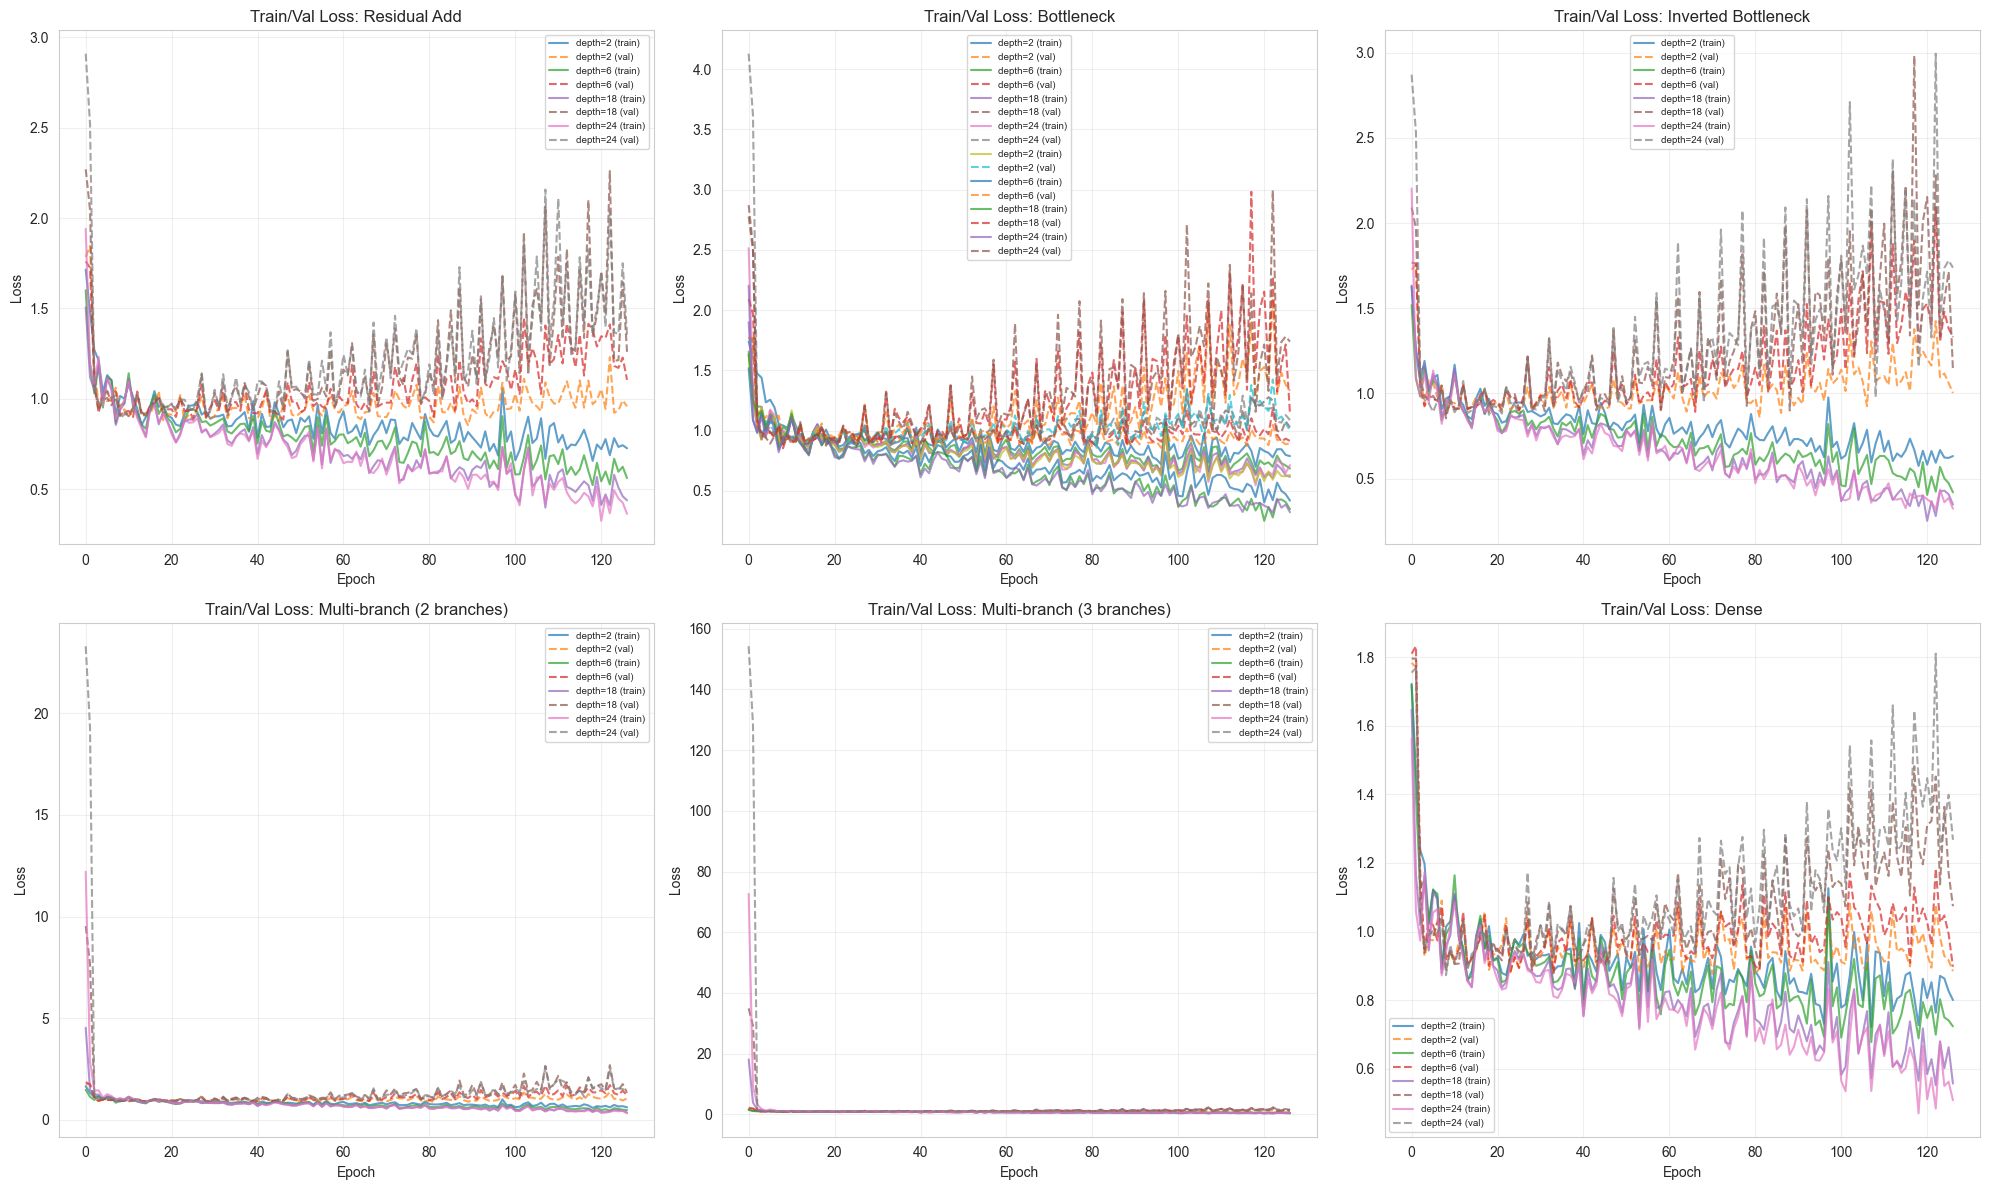

In [11]:
# Визуализация: сравнение всех архитектур
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# График train/val loss для каждой архитектуры
arch_names = list(architectures.keys())
for idx, arch_name in enumerate(arch_names):
    row = idx // 3
    col = idx % 3
    if row < 2 and col < 3:
        ax = axes[row, col]
        for name, history in results_all.items():
            if arch_name in name:
                num_epochs = len(history['val_loss'])
                train_loss_avg = average_train_loss_by_epochs(history['train_loss'], num_epochs)
                epochs = range(num_epochs)
                depth = int(name.split('depth=')[1].split(')')[0])
                ax.plot(epochs, train_loss_avg, label=f"depth={depth} (train)", linestyle='-', alpha=0.7)
                ax.plot(epochs, history['val_loss'], label=f"depth={depth} (val)", linestyle='--', alpha=0.7)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'Train/Val Loss: {arch_name}')
        ax.legend(fontsize=7)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


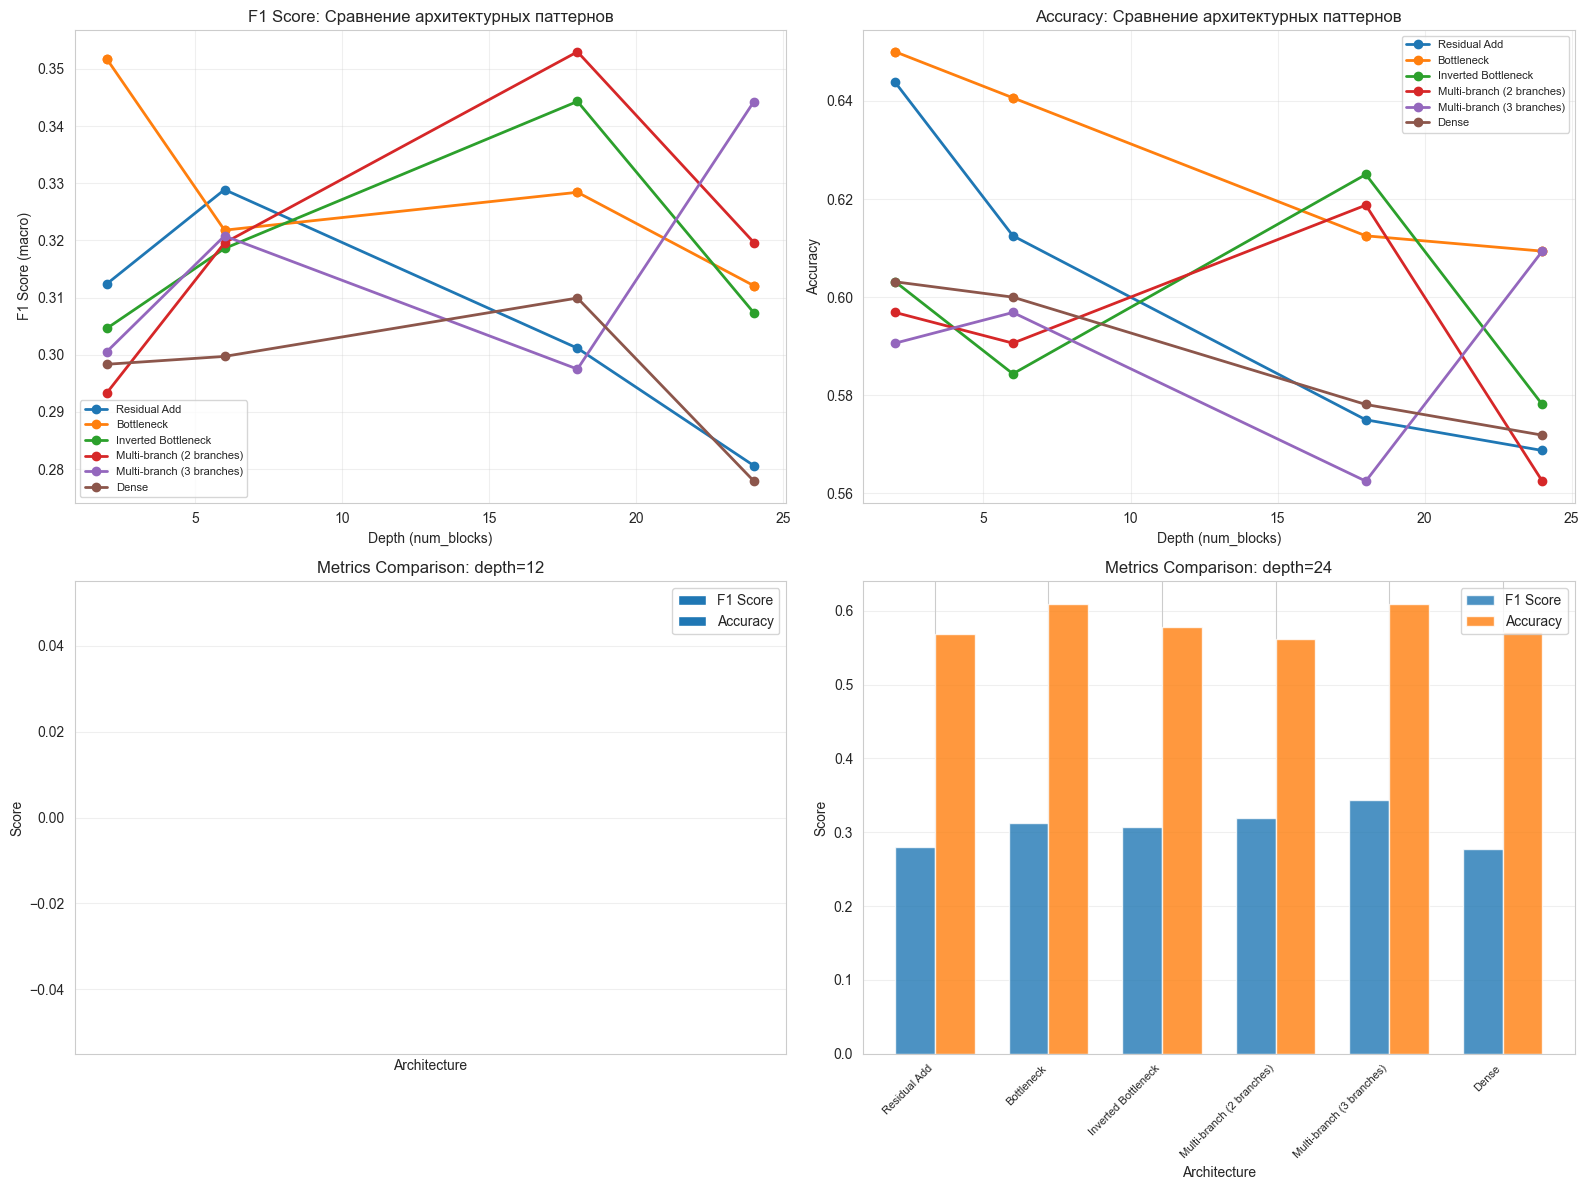

In [12]:
# Сравнение метрик по глубинам
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1 Score по глубинам
ax = axes[0, 0]
for arch_name in arch_names:
    depths_list = sorted([int(n.split('depth=')[1].split(')')[0]) for n in results_all.keys() if arch_name in n])
    f1_scores = [results_all[f"{arch_name} (depth={d})"]['final_f1'] for d in depths_list]
    ax.plot(depths_list, f1_scores, marker='o', label=arch_name, linewidth=2)
ax.set_xlabel('Depth (num_blocks)')
ax.set_ylabel('F1 Score (macro)')
ax.set_title('F1 Score: Сравнение архитектурных паттернов')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Accuracy по глубинам
ax = axes[0, 1]
for arch_name in arch_names:
    depths_list = sorted([int(n.split('depth=')[1].split(')')[0]) for n in results_all.keys() if arch_name in n])
    accuracy_scores = [results_all[f"{arch_name} (depth={d})"]['final_accuracy'] for d in depths_list]
    ax.plot(depths_list, accuracy_scores, marker='o', label=arch_name, linewidth=2)
ax.set_xlabel('Depth (num_blocks)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy: Сравнение архитектурных паттернов')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Сравнение для глубины 12
ax = axes[1, 0]
depth_12_results = {name: results_all[name] for name in results_all.keys() if 'depth=12' in name}
arch_names_12 = [n.split(' (depth=')[0] for n in depth_12_results.keys()]
f1_scores_12 = [depth_12_results[n]['final_f1'] for n in depth_12_results.keys()]
accuracy_scores_12 = [depth_12_results[n]['final_accuracy'] for n in depth_12_results.keys()]

x = np.arange(len(arch_names_12))
width = 0.35
ax.bar(x - width/2, f1_scores_12, width, label='F1 Score', alpha=0.8)
ax.bar(x + width/2, accuracy_scores_12, width, label='Accuracy', alpha=0.8)
ax.set_xlabel('Architecture')
ax.set_ylabel('Score')
ax.set_title('Metrics Comparison: depth=12')
ax.set_xticks(x)
ax.set_xticklabels(arch_names_12, rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Сравнение для глубины 24
ax = axes[1, 1]
depth_24_results = {name: results_all[name] for name in results_all.keys() if 'depth=24' in name}
arch_names_24 = [n.split(' (depth=')[0] for n in depth_24_results.keys()]
f1_scores_24 = [depth_24_results[n]['final_f1'] for n in depth_24_results.keys()]
accuracy_scores_24 = [depth_24_results[n]['final_accuracy'] for n in depth_24_results.keys()]

x = np.arange(len(arch_names_24))
width = 0.35
ax.bar(x - width/2, f1_scores_24, width, label='F1 Score', alpha=0.8)
ax.bar(x + width/2, accuracy_scores_24, width, label='Accuracy', alpha=0.8)
ax.set_xlabel('Architecture')
ax.set_ylabel('Score')
ax.set_title('Metrics Comparison: depth=24')
ax.set_xticks(x)
ax.set_xticklabels(arch_names_24, rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [13]:
# Сводная таблица результатов
results_df = pd.DataFrame({
    'Architecture': [n.split(' (depth=')[0] for n in results_all.keys()],
    'Depth': [int(n.split('depth=')[1].split(')')[0]) for n in results_all.keys()],
    'F1 Score': [results_all[n]['final_f1'] for n in results_all.keys()],
    'Accuracy': [results_all[n]['final_accuracy'] for n in results_all.keys()],
    'Final Val Loss': [results_all[n]['val_loss'][-1] for n in results_all.keys()]
})

results_df = results_df.sort_values(['Architecture', 'Depth'])
print("\n=== Сводная таблица результатов ===")
print(results_df.to_string(index=False))

# Лучшие результаты по архитектурам
print("\n=== Лучшие результаты по архитектурам ===")
for arch_name in arch_names:
    arch_results = results_df[results_df['Architecture'] == arch_name]
    if len(arch_results) > 0:
        best_f1 = arch_results.loc[arch_results['F1 Score'].idxmax()]
        best_acc = arch_results.loc[arch_results['Accuracy'].idxmax()]
        print(f"\n{arch_name}:")
        print(f"  Лучший F1: depth={int(best_f1['Depth'])}, F1={best_f1['F1 Score']:.4f}")
        print(f"  Лучший Accuracy: depth={int(best_acc['Depth'])}, Accuracy={best_acc['Accuracy']:.4f}")



=== Сводная таблица результатов ===
             Architecture  Depth  F1 Score  Accuracy  Final Val Loss
               Bottleneck      2  0.351711  0.650000        0.894066
               Bottleneck      6  0.321789  0.640625        0.914988
               Bottleneck     18  0.328416  0.612500        1.027111
               Bottleneck     24  0.312073  0.609375        1.088095
                    Dense      2  0.298339  0.603125        0.884369
                    Dense      6  0.299715  0.600000        0.897221
                    Dense     18  0.309925  0.578125        1.073815
                    Dense     24  0.277902  0.571875        1.267742
      Inverted Bottleneck      2  0.304623  0.603125        1.003051
      Inverted Bottleneck      6  0.318587  0.584375        1.330893
      Inverted Bottleneck     18  0.344303  0.625000        1.140310
      Inverted Bottleneck     24  0.307327  0.578125        1.738678
Multi-branch (2 branches)      2  0.293348  0.596875        1.0516